# Opcode Frequency - MultiOutputClassifier(AdaBoostClassifier())

## Set Up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import re
import json
import pickle
import pandas as pd
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import sys
# Add the workspace root to sys.path so 'scripts' can be imported
sys.path.append(str(Path.cwd().parents[3]))

from scripts.feature_extractions.opcode_freq import get_opcodes_freq_from_files


In [3]:
PATH = Path.cwd().parents[3]
MODEL_PATH = os.path.join(PATH, 'models/baseline')
DATA_PATH = os.path.join(PATH, 'data')
EX_PATH = os.path.join(DATA_PATH, 'external/crpwarner/large')
HEX_PATH = os.path.join(EX_PATH, 'hex')
name = 'opcode_freq'

### Load Model

In [4]:
model_paths = list(Path(MODEL_PATH).glob(f'{name}-f1-*.pkl'))

In [5]:
def get_best_model_path(paths):
    best_f1_score = -1.0
    best_path = None

    for path in paths:
        # Extract the F1 score using a regular expression
        match = re.search(r'f1-(\d+\.\d+)\.(pkl|json|keras)$', path.name)
        if match:
            try:
                f1_score = float(match.group(1))
                if f1_score > best_f1_score:
                    best_f1_score = f1_score
                    best_path = path
            except ValueError:
                # Handle cases where the extracted string might not be a valid float
                print(f"Warning: Could not parse F1 score from filename: {path.name}")
        else:
            print(f"Warning: F1 score pattern not found in filename: {path.name}")

    return best_path

In [6]:
best_model_path = get_best_model_path(model_paths)

if best_model_path:
    model = pickle.load(open(best_model_path, 'rb'))

In [7]:
with open(os.path.join(DATA_PATH, f'processed/{name}/features.json'), 'r', encoding='utf-8') as f:
    train_cols = json.load(f)

In [8]:
train_cols

['PUSH',
 'MSTORE',
 'CALLDATASIZE',
 'LT',
 'JUMPI',
 'CALLDATALOAD',
 'SWAP',
 'DIV',
 'AND',
 'DUP',
 'EQ',
 'JUMPDEST',
 'REVERT',
 'CALLVALUE',
 'ISZERO',
 'POP',
 'JUMP',
 'MLOAD',
 'ADD',
 'SUB',
 'EXP',
 'NOT',
 'RETURN',
 'STOP',
 'SLOAD',
 'MUL',
 'SHA',
 'GT',
 'CALLER',
 'SSTORE',
 'LOG',
 'OR',
 'UNKNOWN',
 'MSIZE',
 'CHAINID',
 'SMOD',
 'ADDRESS',
 'PC',
 'SHR',
 'SHL',
 'CODECOPY',
 'SLT',
 'COINBASE',
 'TIMESTAMP',
 'CALLDATACOPY',
 'RETURNDATASIZE',
 'ADDMOD',
 'EXTCODESIZE',
 'BYTE',
 'CODESIZE',
 'SELFBALANCE',
 'EXTCODEHASH',
 'INVALID',
 'GASLIMIT',
 'NUMBER',
 'ORIGIN',
 'GASPRICE',
 'GAS',
 'STATICCALL',
 'RETURNDATACOPY',
 'MOD',
 'CALL',
 'SAR',
 'CREATE',
 'UNOFFICIAL',
 'BLOCKHASH',
 'XOR',
 'SELFDESTRUCT',
 'MULMOD',
 'DIFFICULTY',
 'BALANCE',
 'BASEFEE',
 'SDIV',
 'CALLCODE',
 'SGT',
 'EXTCODECOPY',
 'SIGNEXTEND',
 'DELEGATECALL']

## Mint

### Load and Prepare Data

In [9]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/mint.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0x0fef20d2c4ee011fa0389e69e9fa92a2291b63c8,Yes
0xd7cc0deb9dd11be95068bf2d7a3d082b8ba9bf04,Yes
0xa1b756be589441519b1a08e16bc4f60ab177d916,Yes
0x514bc174df04a4b04ae2be81ee8c788c3796b06b,Yes
0x1354c8c1a66c2573ce9cc3e92e98d17869501a46,Yes


In [10]:
df.isna().sum()

TP?    0
dtype: int64

In [11]:
files = []
y = []

for path in list(Path(HEX_PATH).glob('*.hex')):
    address = path.stem.lower()
    if address in df.index:
        files.append(path)
        tp_value = df.loc[address, 'TP?']
        if isinstance(tp_value, pd.Series):
            tp_value = tp_value.iloc[0]
        y.append(1 if tp_value == 'Yes' else 0)

X = get_opcodes_freq_from_files(files)

  0%|          | 0/92 [00:00<?, ?it/s]invalid instruction: PUSH18
invalid instruction: PUSH32
  4%|▍         | 4/92 [00:00<00:02, 32.81it/s]invalid instruction: PUSH31
invalid instruction: PUSH27
invalid instruction: PUSH27
  9%|▊         | 8/92 [00:00<00:03, 25.31it/s]invalid instruction: PUSH25
invalid instruction: PUSH32
 14%|█▍        | 13/92 [00:00<00:02, 32.31it/s]invalid instruction: PUSH32
invalid instruction: PUSH15
invalid instruction: PUSH22
 20%|█▉        | 18/92 [00:00<00:02, 35.11it/s]invalid instruction: PUSH31
invalid instruction: PUSH31
 24%|██▍       | 22/92 [00:00<00:02, 30.58it/s]invalid instruction: PUSH17
invalid instruction: PUSH28
 29%|██▉       | 27/92 [00:00<00:01, 35.05it/s]invalid instruction: PUSH18
invalid instruction: PUSH19
invalid instruction: PUSH24
invalid instruction: PUSH23
 36%|███▌      | 33/92 [00:00<00:01, 40.15it/s]invalid instruction: PUSH25
invalid instruction: PUSH9
invalid instruction: PUSH20
 41%|████▏     | 38/92 [00:01<00:01, 35.56it/s]i

In [12]:
X

,PUSH,MSTORE,CALLDATASIZE,LT,JUMPI,CALLDATALOAD,SWAP,DIV,AND,DUP,...,BLOCKHASH,ORIGIN,BYTE,SDIV,SLT,XOR,STATICCALL,GASPRICE,DIFFICULTY,EXTCODEHASH
address,,,,,,,,,,,,,,,,,,,,,
0x71a982a028c9d4b0566041a78df12b810462e155,701,103,15,10,75,27,372,20,118,565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x8d3bd2940bbc5ed724d138934374e4c0ad3c0027,837,111,1,13,87,14,413,37,159,532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x4c0c2052dfdb2d0932644f7b2d4bea509678b9d9,1031,133,1,11,108,28,468,34,186,587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x0d42fb07a685d2ff9d6bb93df0389946192cd322,1014,90,1,14,130,18,458,35,173,553,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x7dd2f15b4a8c8e14da5eaa7b635221d4b39c41cc,369,66,1,3,43,16,168,1,54,235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x7e9d5e7655bf3ee30043ca24a55eb6f799e0ee54,745,122,1,6,62,19,351,17,160,473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x03260e1b0f53e1a1f93cf126a7ca42a1c71648d6,514,104,1,5,57,18,270,7,66,360,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xfdf475788c31c57e85f2c48add16164fb5ac84e3,578,84,1,9,72,27,226,11,79,364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
y[:5]

[1, 1, 1, 1, 1]

In [14]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)

### Evaluate

In [15]:
y_pred = model.predict(X)

In [16]:
y_pred = y_pred[:, 0]

In [17]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.17      1.00      0.29        14
           1       1.00      0.10      0.19        78

    accuracy                           0.24        92
   macro avg       0.58      0.55      0.24        92
weighted avg       0.87      0.24      0.20        92



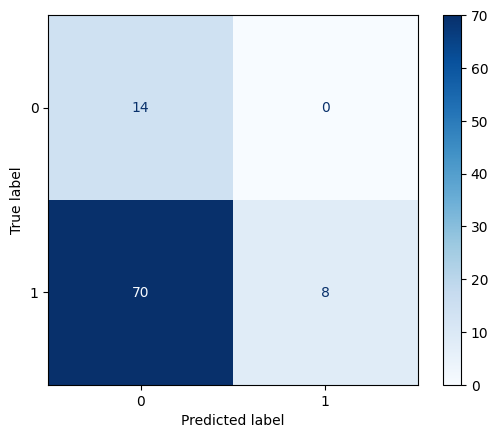

In [18]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

## Leak

### Load and Prepare Data

In [19]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/leak.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0x0290ea3c728981725689187763f6c63a68e192b8,Yes
0x054ad3cd4a66f14bf5c0de2548a53be66995a4f6,Yes
0x0566c17dc2a9efcaa2f63e04cf06a69e8fc77f60,No
0x10c8324b20b7266c445944f043f53f6a77ea0bd4,Yes
0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,Yes


In [20]:
df.isna().sum()

TP?    0
dtype: int64

In [21]:
files = []
y = []

for path in list(Path(HEX_PATH).glob('*.hex')):
    address = path.stem.lower()
    if address in df.index:
        files.append(path)
        tp_value = df.loc[address, 'TP?']
        if isinstance(tp_value, pd.Series):
            tp_value = tp_value.iloc[0]
        y.append(1 if tp_value == 'Yes' else 0)

X = get_opcodes_freq_from_files(files)

  9%|▉         | 8/87 [00:00<00:02, 28.32it/s]invalid instruction: PUSH28
invalid instruction: PUSH30
invalid instruction: PUSH17
 17%|█▋        | 15/87 [00:00<00:02, 25.48it/s]invalid instruction: PUSH14
invalid instruction: PUSH28
invalid instruction: PUSH30
invalid instruction: PUSH24
invalid instruction: PUSH27
 24%|██▍       | 21/87 [00:00<00:01, 33.80it/s]invalid instruction: PUSH30
invalid instruction: PUSH27
 29%|██▊       | 25/87 [00:00<00:02, 27.78it/s]invalid instruction: PUSH23
invalid instruction: PUSH8
invalid instruction: PUSH17
 33%|███▎      | 29/87 [00:01<00:02, 21.94it/s]invalid instruction: PUSH8
invalid instruction: PUSH5
invalid instruction: PUSH10
 38%|███▊      | 33/87 [00:01<00:02, 24.56it/s]invalid instruction: PUSH32
invalid instruction: PUSH23
 41%|████▏     | 36/87 [00:01<00:02, 22.29it/s]invalid instruction: PUSH17
invalid instruction: PUSH19
invalid instruction: PUSH32
invalid instruction: PUSH27
 54%|█████▍    | 47/87 [00:01<00:01, 32.80it/s]invalid inst

In [22]:
X

,PUSH,MSTORE,CALLDATASIZE,LT,JUMPI,CALLDATALOAD,SWAP,DIV,AND,DUP,...,COINBASE,PC,EXTCODEHASH,SHR,BASEFEE,ADDMOD,STATICCALL,SAR,DIFFICULTY,SIGNEXTEND
address,,,,,,,,,,,,,,,,,,,,,
0xf6962cfe3b9618374097d51bc6691efb3974d06f,1031,105,1,16,121,17,474,41,187,568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x666c549f5a01167f1aa19bb68be552441f520895,550,105,1,11,73,25,245,3,61,389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x76bc9e61a1904b82cbf70d1fd9c0f8a120483bbb,658,85,1,17,78,12,379,30,71,456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,1338,76,2,9,180,27,576,67,264,671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xa99f34b4672ff3a9837fd93dea375ccfbb83c89a,946,147,2,17,115,29,401,9,116,580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x8a52499ff8c65cedd4d7ccc283a0dab6df285fe2,1020,169,8,14,105,50,578,21,130,806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x6b9ee9e79bb893d394da79e2ea51685d1855318e,885,142,9,20,91,19,383,6,77,573,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
0xdf482745749ad7057f4ebe246975ff2f2ddeef78,576,84,1,10,72,27,224,11,79,364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
y[:5]

[1, 1, 1, 1, 0]

In [24]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)

### Evaluate

In [25]:
y_pred = model.predict(X)

In [26]:
y_pred = y_pred[:, 1]

In [27]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.16      1.00      0.28        13
           1       1.00      0.09      0.17        74

    accuracy                           0.23        87
   macro avg       0.58      0.55      0.23        87
weighted avg       0.87      0.23      0.19        87



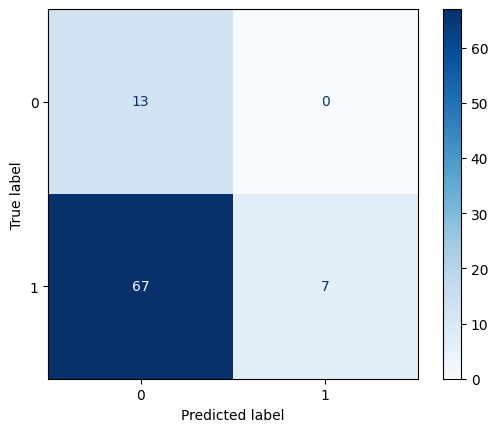

In [28]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

## Limit

### Load and Prepare Data

In [29]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/limit.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0xe5f3c6d2b47cbe2cf936b9521466bac2422ebef8,Yes
0xa623b5a542c0d7daadef321042a04c600b03a8cb,Yes
0xe412189da2dfa188a1a61633114b8732bbbfba19,Yes
0x9fcf7acdc11fd904c4b73a009909c7f00efc4844,Yes
0x921a5dce3dfed5cccfbb2e593f2978533bc66110,Yes


In [30]:
df.isna().sum()

TP?    0
dtype: int64

In [31]:
files = []
y = []

for path in list(Path(HEX_PATH).glob('*.hex')):
    address = path.stem.lower()
    if address in df.index:
        files.append(path)
        tp_value = df.loc[address, 'TP?']
        if isinstance(tp_value, pd.Series):
            tp_value = tp_value.iloc[0]
        y.append(1 if tp_value == 'Yes' else 0)

X = get_opcodes_freq_from_files(files)

  0%|          | 0/91 [00:00<?, ?it/s]invalid instruction: PUSH32
invalid instruction: PUSH20
invalid instruction: PUSH11
  8%|▊         | 7/91 [00:00<00:01, 69.05it/s]invalid instruction: PUSH19
invalid instruction: PUSH5
invalid instruction: PUSH28
invalid instruction: PUSH29
 15%|█▌        | 14/91 [00:00<00:01, 42.65it/s]invalid instruction: PUSH25
invalid instruction: PUSH17
invalid instruction: PUSH26
invalid instruction: PUSH28
invalid instruction: PUSH29
 22%|██▏       | 20/91 [00:00<00:01, 47.24it/s]invalid instruction: PUSH21
invalid instruction: PUSH28
invalid instruction: PUSH13
 29%|██▊       | 26/91 [00:00<00:01, 38.58it/s]invalid instruction: PUSH29
invalid instruction: PUSH27
invalid instruction: PUSH29
invalid instruction: PUSH18
invalid instruction: PUSH30
invalid instruction: PUSH32
 36%|███▋      | 33/91 [00:00<00:01, 31.16it/s]invalid instruction: PUSH22
invalid instruction: PUSH29
invalid instruction: PUSH26
invalid instruction: PUSH10
 42%|████▏     | 38/91 [00:01

In [32]:
X

,PUSH,MSTORE,CALLDATASIZE,LT,JUMPI,CALLDATALOAD,SWAP,DIV,AND,DUP,...,SELFBALANCE,MSIZE,BASEFEE,SLT,STATICCALL,SGT,SDIV,CODESIZE,SMOD,EXTCODEHASH
address,,,,,,,,,,,,,,,,,,,,,
0x1f4a9567c1f98a8c9d7f026827f099b41a2e54d6,699,86,12.0,4.0,73,19,347,30,156,417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x76bc9e61a1904b82cbf70d1fd9c0f8a120483bbb,658,85,1.0,17.0,78,12,379,30,71,456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xa5d77efbc45d574b689d7f1202cf817e23febb97,516,86,2.0,7.0,72,27,251,9,54,408,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xb08fc1db58ef5e15a6f97d8f63b2bb4a14b9df37,278,41,1.0,0.0,25,7,105,11,45,133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x40165bd6d657b63cb6f8f4a3525ac05bbf74bd93,893,140,15.0,23.0,105,26,453,11,113,640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x4c567c3363cc42c5a42c6d8bf01503fd1d0b91cd,848,139,1.0,4.0,69,21,368,15,168,469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x3fb1926a7d1cc68d4166d99c3483465885074f2f,636,102,13.0,10.0,62,24,346,18,113,516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xfb5fb992b64c86fbcb33ba151abd8ecbcc611bde,796,114,16.0,9.0,82,30,446,30,148,606,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
y[:5]

[1, 1, 1, 0, 1]

In [34]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)

### Evaluate

In [35]:
y_pred = model.predict(X)

In [36]:
y_pred = y_pred[:, 2]

In [37]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.10      0.62      0.17        13
           1       0.38      0.04      0.07        78

    accuracy                           0.12        91
   macro avg       0.24      0.33      0.12        91
weighted avg       0.34      0.12      0.08        91



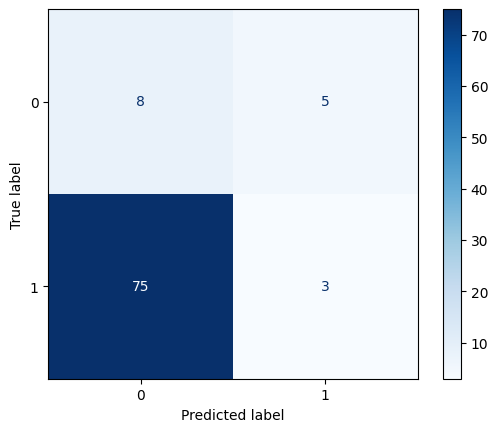

In [38]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()